<a href="https://colab.research.google.com/github/jibbsmathew/Uber-Trips-Analysis/blob/main/AnalysingUberTrips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Navigating NYC: A Deep Dive into Uber Trips Analysis

Delving into the wealth of data provided by Uber trips in New York City unveils fascinating patterns that shed light on the dynamics of the city's intricate transportation system. In this analysis, I utilize a dataset comprising approximately 4.5 million Uber pickups from April to September and an additional 14.3 million pickups from January to June 2015. New York, with its complex transportation network and expansive residential community, serves as a captivating backdrop for this exploration.

Beyond merely scrutinizing the dataset, there's immense potential for extracting valuable insights and drawing nuanced conclusions. In the following section, I will guide you through a comprehensive Uber Trips analysis using Python, offering a deeper understanding of the trends and intricacies within the data.



In [46]:
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import os, sys, itertools, re
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

if 'google.colab' in sys.modules:
    project_path =  "/content/drive/My Drive/"
    # Google Colab lib
    from google.colab import drive
    # Mount the drive
    drive.mount('/content/drive/', force_remount=True)
    sys.path.append(project_path)
    %cd $project_path

Mounted at /content/drive/
/content/drive/My Drive


In [47]:
df = pd.read_csv("data/uberrawdata.csv")
df.head()

,Date/Time,Lat,Lon,Base
0,9/1/2014 0:01:00,40.2201,-74.0021,B02512
1,9/1/2014 0:01:00,40.7500,-74.0027,B02512
2,9/1/2014 0:03:00,40.7559,-73.9864,B02512
3,9/1/2014 0:06:00,40.7450,-73.9889,B02512
4,9/1/2014 0:11:00,40.8145,-73.9444,B02512


The dataset comprises essential information including date and time, latitude and longitude coordinates, and a Base column containing codes associated with Uber pickups. If you're interested in exploring additional datasets for Uber trip analysis, you can access them through this [link](https://www.kaggle.com/account/login?titleType=dataset-downloads&showDatasetDownloadSkip=False&messageId=datasetsWelcome&returnUrl=%2Fdatasets%2Ffivethirtyeight%2Fuber-pickups-in-new-york-city%3Fresource%3Ddownload). For the purpose of our current analysis, let's focus on preparing the data at hand, aiming to dissect Uber trips based on days and hours.

In [48]:
import pandas as pd

# Assuming df["Date/Time"] is in string format
df["Date/Time"] = pd.to_datetime(df["Date/Time"])

df["Day"] = df["Date/Time"].dt.day
df["Weekday"] = df["Date/Time"].dt.weekday
df["Hour"] = df["Date/Time"].dt.hour

print(df.head())

            Date/Time      Lat      Lon    Base  Day  Weekday  Hour
0 2014-09-01 00:01:00  40.2201 -74.0021  B02512    1        0     0
1 2014-09-01 00:01:00  40.7500 -74.0027  B02512    1        0     0
2 2014-09-01 00:03:00  40.7559 -73.9864  B02512    1        0     0
3 2014-09-01 00:06:00  40.7450 -73.9889  B02512    1        0     0
4 2014-09-01 00:11:00  40.8145 -73.9444  B02512    1        0     0


So I have prepared this data according to the days and hours, as I am using the Uber trips for the September month so let’s have a look at each day to see on which day the Uber trips were highest:

<ipython-input-49-ba2c35e301de>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Day"])


<Axes: xlabel='Day', ylabel='Density'>

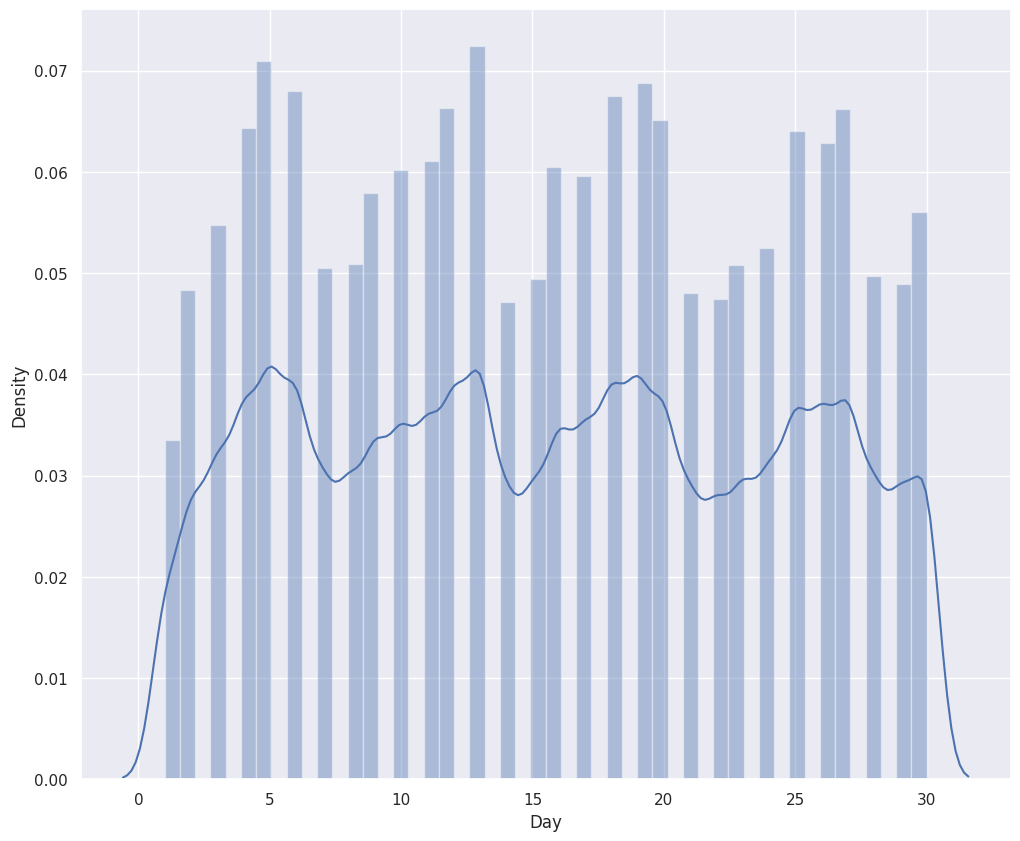

In [49]:
sns.set(rc={'figure.figsize':(12, 10)})
sns.distplot(df["Day"])

By looking at the daily trips we can say that the Uber trips are rising on the working days and decreases on the weekends. Now let’s analyze the Uber trips according to the hours:

<ipython-input-50-5f788edde53d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Hour"])


<Axes: xlabel='Hour', ylabel='Density'>

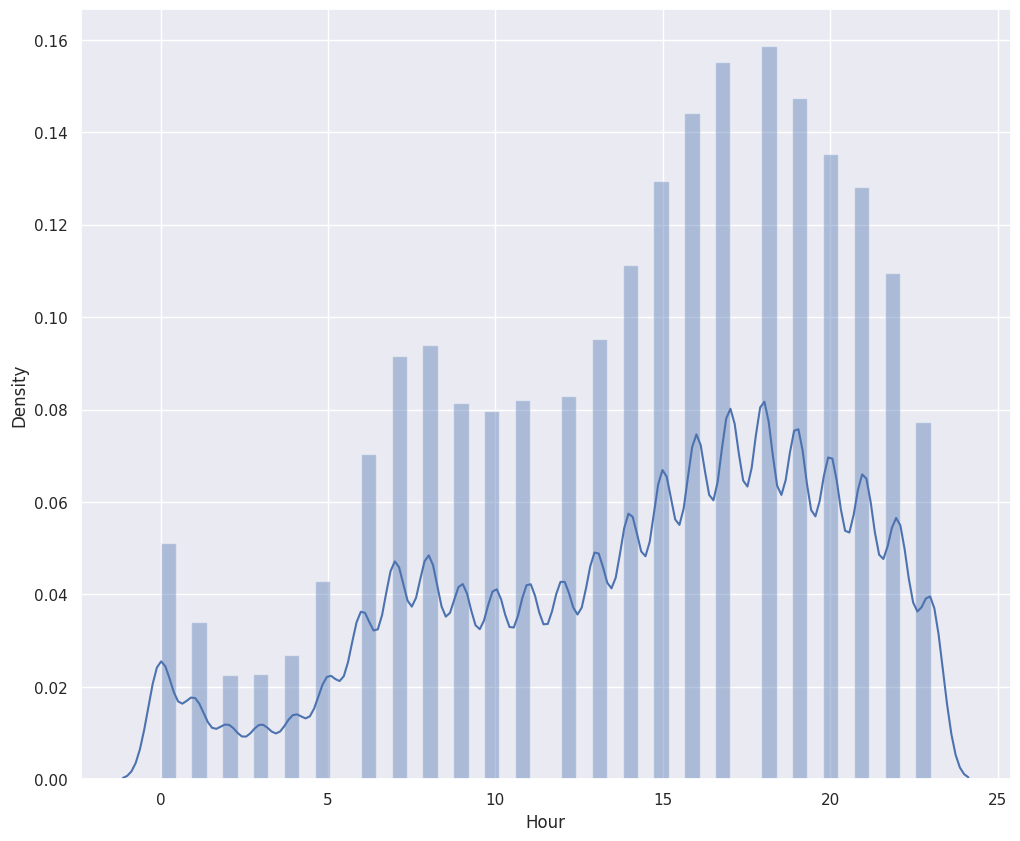

In [50]:
sns.distplot(df["Hour"])

According to the hourly data, the Uber trips decreases after midnight and then start increasing after 5 am and the trips keep rising till 6 pm such that 6 pm is the busiest hour for Uber then the trips start decreasing. Now let’s analyze the Uber trips according to the weekdays:

<ipython-input-51-3aeab2e17408>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Weekday"])


<Axes: xlabel='Weekday', ylabel='Density'>

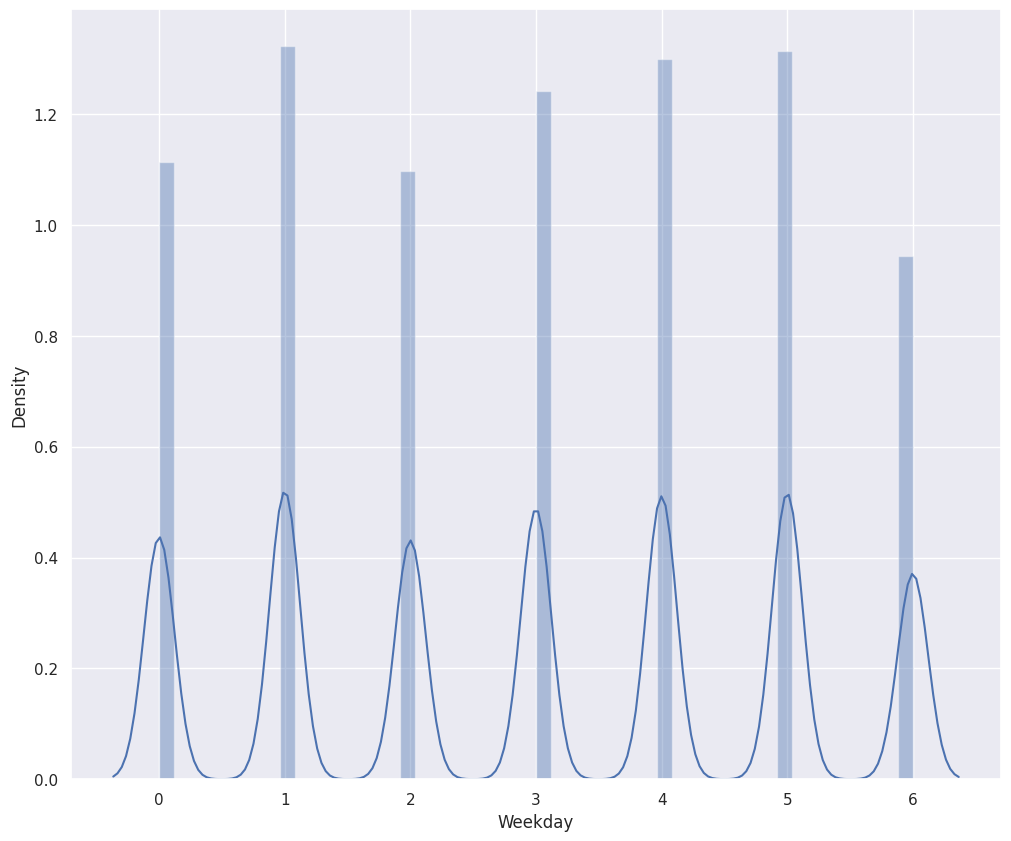

In [51]:
sns.distplot(df["Weekday"])

In the above figure 0 indicates Sunday, on Sundays the Uber trips and more than Saturdays so we can say people also use Uber for outings rather than for just going to work. On Saturdays, the Uber trips are the lowest and on Mondays, they are the highest. Now let’s have a look at the correlation of hours and weekdays on the Uber trips:

<Axes: xlabel='Hour', ylabel='Weekday'>

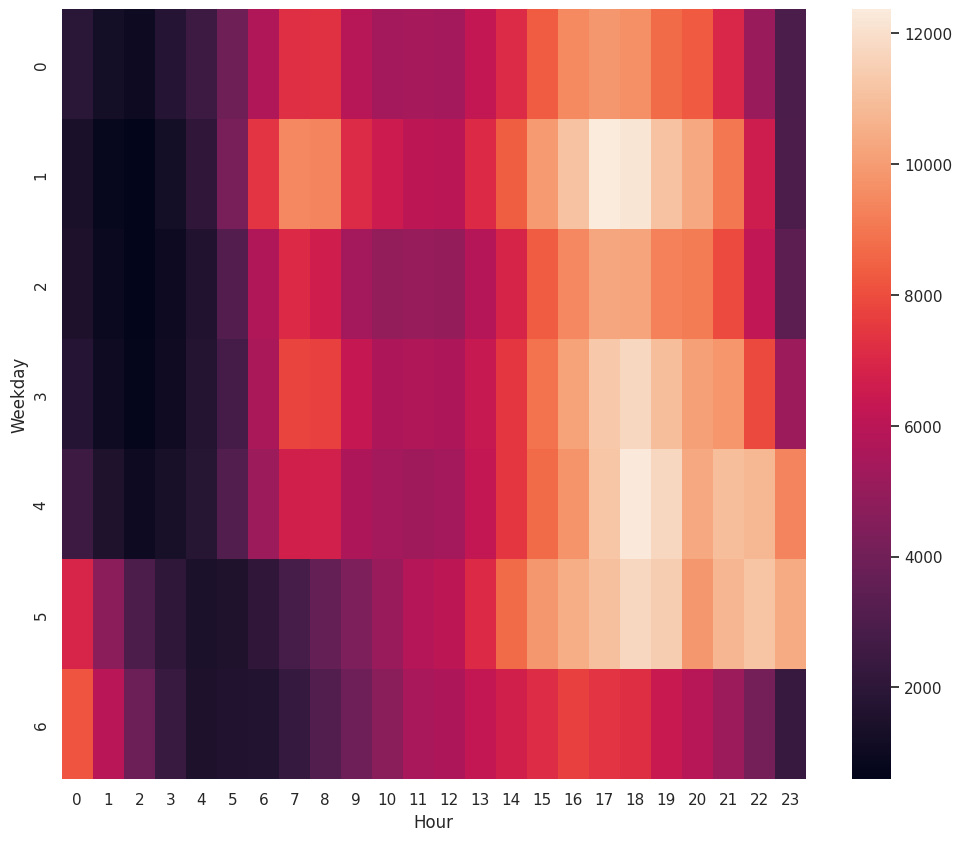

In [52]:
# Correlation of Weekday and Hour
df1 = df.groupby(["Weekday", "Hour"]).apply(lambda x: len(x))
df1 = df1.unstack()
sns.heatmap(df1, annot=False)

As we are having the data about longitude and latitude so we can also plot the density of Uber trips according to the regions of the New Your city:

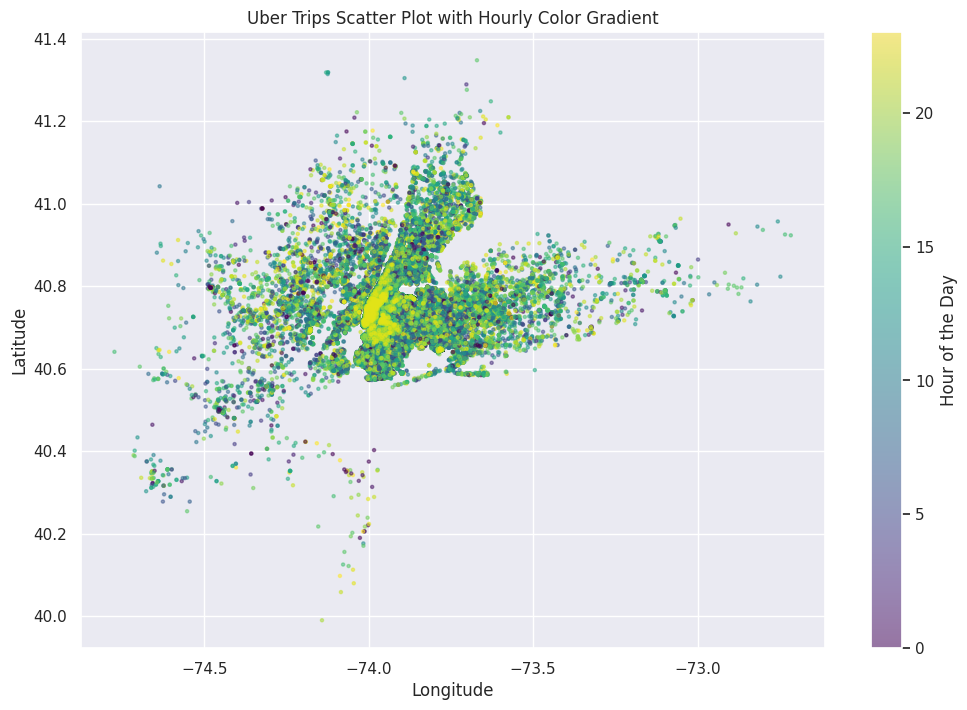

In [55]:
plt.figure(figsize=(12, 8))
plt.scatter(df['Lon'], df['Lat'], c=df['Hour'], cmap='viridis', alpha=0.5, s=5)
plt.colorbar(label='Hour of the Day')
plt.title('Uber Trips Scatter Plot with Hourly Color Gradient')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
